In [31]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.constants import h, c, k_B, m_p
import matplotlib.pyplot as plt

# Constants used 
t = 5800 #Temp of sun for now can change for what we are looking at 
rad = 6.96e8 #Radius of sun in meters for now will change to bh later
d = 1.5e11 #distance from earth to sun in meters 
h = h.value #Planck constant
c = c.value #speed of light
k = k_B.value #Boltzmann constant
m_p = m_p.value #proton mass
pi = np.pi #Pi constant
v_fs = 0.1 * c #velocity of forward shock (used in Beta)
dens = 10e-15 #density of agn disk



# Reading and convering the LSST filter data

r = pd.read_csv('../data/filters/LSST_r.dat', delim_whitespace=True)
#red filter from 5371-7059
g = pd.read_csv('../data/filters//LSST_g.dat', delim_whitespace=True)
# green filter from 3865-5669
i = pd.read_csv('../data/filters//LSST_i.dat', delim_whitespace=True)
# infrared filter from 6761-8329
u = pd.read_csv('../data/filters//LSST_u.dat', delim_whitespace=True)
# ultraviolet filter from 3201-4085
y = pd.read_csv('../data/filters//LSST_y.dat', delim_whitespace=True)
# y filter from 9085-10989
z = pd.read_csv('../data/filters//LSST_z.dat', delim_whitespace=True)
# z filter from 8031-9385
r_eff = r.iloc[:, 1]  # 0 for wavelength 1 for transmission
g_eff = g.iloc[:, 1]
i_eff = i.iloc[:, 1]  
u_eff = u.iloc[:, 1]
y_eff = y.iloc[:, 1]
z_eff = z.iloc[:, 1]


r_filter = r.iloc[:, 0]  # 0 for wavelength 1 for transmission
g_filter = g.iloc[:, 0]
i_filter = i.iloc[:, 0]  
u_filter = u.iloc[:, 0]
y_filter = y.iloc[:, 0]
z_filter = z.iloc[:, 0]

r_wave = r_filter * 1e-10 # I think its in angstroms  
g_wave = g_filter * 1e-10
i_wave = i_filter * 1e-10
u_wave = u_filter * 1e-10
y_wave = y_filter * 1e-10
z_wave = z_filter * 1e-10

# converting wavelength to frequency
r_freq = c/r_wave #using c already below as 3e8
g_freq = c/g_wave
i_freq = c/i_wave
u_freq = c/u_wave
y_freq = c/y_wave
z_freq = c/z_wave


#planck law for freq
l_r = r_wave # wavelngth too just easier to use this in formula 
l_g = g_wave
l_i = i_wave
l_u = u_wave
l_y = y_wave
l_z = z_wave
# Plancks law for frequency

def planck_fxn(filter, T = t):
    B = (((2*h*(filter**3))/(c**2)))*((1/(np.exp((h*filter)/(k*T))-1)))
    return B

planck_r = planck_fxn(r_freq)
planck_g = planck_fxn(g_freq)
planck_i = planck_fxn(i_freq) 
planck_u = planck_fxn(u_freq)
planck_y = planck_fxn(y_freq)
planck_z = planck_fxn(z_freq)

# Combining the filter data and planck law 

r_trans = planck_r * r_eff #total output for given filter
g_trans = planck_g * g_eff
i_trans = planck_i * i_eff
u_trans = planck_u * u_eff
y_trans = planck_y * y_eff
z_trans = planck_z * z_eff

r_total = sum(r_trans) #combinging the 1600ish values in each filter for total output
g_total = sum(g_trans)
i_total = sum(i_trans)
u_total = sum(u_trans)
y_total = sum(y_trans)
z_total = sum(z_trans)

#ratio of highest output to other filters
r_ratio = r_total / i_total
g_ratio = g_total / i_total
i_ratio = i_total / i_total
u_ratio = u_total / i_total
y_ratio = y_total / i_total
z_ratio = z_total / i_total

#Planck law graph
total_wave = np.concatenate((r_wave, g_wave, i_wave, u_wave, y_wave, z_wave)) #combining all the wavelengths in one 
planck_total = np.concatenate((planck_r, planck_g, planck_i, planck_u, planck_y, planck_z)) #Full Planck law
trans_total = np.concatenate((r_trans, g_trans, i_trans, u_trans, y_trans, z_trans))
total_freq = np.concatenate((r_freq, g_freq, i_freq, u_freq, y_freq, z_freq))#sorting the frequency values
sorted_freq = np.sort(total_freq)

# To make plancks law graph smooth 
total_index = np.argsort(total_freq)
total_wave = total_wave[total_index]
planck_total = (planck_total[total_index])  

# planck law based on area
planck_area = (planck_total * pi * (rad*2))

# planck law based on distance 
planck_dist = (planck_area/(4 * pi * (d**2)))

#velocity to beta/gamma
b_fs = v_fs/c #beta
gamma_fs = 1/((1-b_fs**2)**0.5) #gamma forward shock
gamma_fs_f = gamma_fs**(1+3**0.5) #only true if gamma_fs is below 4
gamma_sf = gamma_fs/(2**0.5) #gamme of shock fluid
gamma_sf_f = gamma_sf**(1+3**0.5) #if at angle of jet

#for when b is less than 0.03 we just need temp and put into planck law
t_low_v = 10**4 * ((b_fs/0.02)**0.5)*((dens/1e-16)**0.25)

#temp to use in wien when 0.03< b < 1
n = dens/m_p #density of AGN over proton mass

t_mid = 0.975 + 1.75 * ((b_fs/0.1) **0.5) + ((0.26-0.08*((b_fs/0.1) **0.5)) * np.log10(n/(10**15)))

#for when b is greater than 0.03 but less than 1 use wien
wien_r = ((2 * h * (r_filter**3)) / (c**2)) * np.exp(-((h * r_filter)/(k * t_mid)))
wien_g = ((2 * h * (g_filter**3)) / (c**2)) * np.exp(-((h * g_filter)/(k * t_mid)))
wien_i = ((2 * h * (i_filter**3)) / (c**2)) * np.exp(-((h * i_filter)/(k * t_mid)))
wien_u = ((2 * h * (u_filter**3)) / (c**2)) * np.exp(-((h * u_filter)/(k * t_mid)))
wien_y = ((2 * h * (y_filter**3)) / (c**2)) * np.exp(-((h * y_filter)/(k * t_mid)))
wien_z = ((2 * h * (z_filter**3)) / (c**2)) * np.exp(-((h * z_filter)/(k * t_mid)))

wien_freq = np.concatenate((wien_r, wien_g, wien_i, wien_u, wien_y, wien_z)) #combining all the wien values
wien_total = (wien_freq[total_index])  # sorting the wien values 

# when b is greater than 1

t_high = (gamma_sf_f*5e3)/k


print(t_mid)
print(wien_r)


2.324788398709255
0       2.284599e-39
1       2.285876e-39
2       2.287152e-39
3       2.288430e-39
4       2.289707e-39
            ...     
1684    5.177685e-39
1685    5.179887e-39
1686    5.182089e-39
1687    5.184293e-39
1688    5.186497e-39
Name: 5370, Length: 1689, dtype: float64


/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_1857/3504163354.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  r = pd.read_csv('../data/filters/LSST_r.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_1857/3504163354.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  g = pd.read_csv('../data/filters//LSST_g.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_1857/3504163354.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  i = pd.read_csv('../data/filters//LSST_i.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_1857/3504163354.py:29: FutureWarning: The 'delim_white

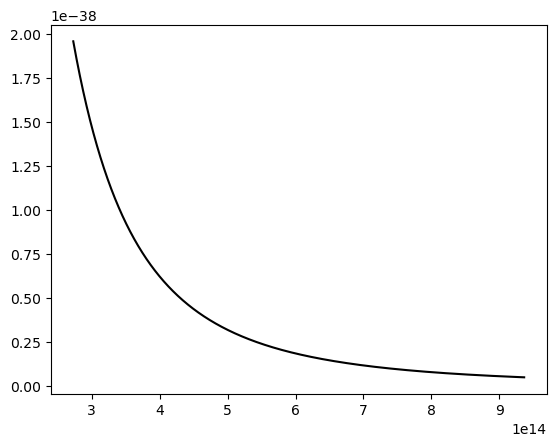

In [32]:

plt.plot(sorted_freq, wien_total, color='black', label="Wien's Law")

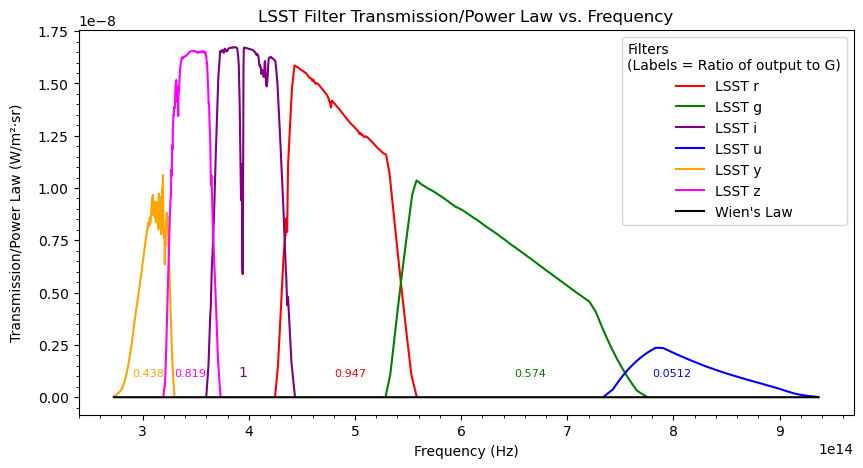

In [30]:
# Plot Code
plt.figure(figsize=(10, 5))
plt.plot(r_freq, r_trans, color='red', label='LSST r')
plt.plot(g_freq, g_trans, color='green', label='LSST g')
plt.plot(i_freq, i_trans, color='purple', label='LSST i')
plt.plot(u_freq, u_trans, color='blue', label='LSST u')
plt.plot(y_freq, y_trans, color='orange', label='LSST y')
plt.plot(z_freq, z_trans, color='magenta', label='LSST z')
plt.plot(sorted_freq, wien_total, color='black', label="Wien's Law")


#labels
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission/Power Law (W/m²·sr)", labelpad=10)
plt.minorticks_on()  # Add ticks inside the axis
plt.title("LSST Filter Transmission/Power Law vs. Frequency")
plt.annotate(f'{u_ratio:.3g}', (7.8e14, 0.1e-8), fontsize=8, color='blue') #for u filter
plt.annotate(f'{g_ratio:.3g}', (6.5e14, 0.1e-8), fontsize=8, color='green') #for g filter
plt.annotate(f'{r_ratio:.3g}', (4.8e14, 0.1e-8), fontsize=8, color='red') #for r filter
plt.annotate(f'{i_ratio:.3g}', (3.9e14, 0.1e-8), fontsize=10, color='purple') #for i filter
plt.annotate(f'{y_ratio:.3g}', (2.9e14, 0.1e-8), fontsize=8, color='orange') #for y filter
plt.annotate(f'{z_ratio:.3g}', (3.3e14, 0.1e-8), fontsize=8, color='magenta') #for z filter
plt.legend(title="Filters\n(Labels = Ratio of output to G)",loc='upper right')

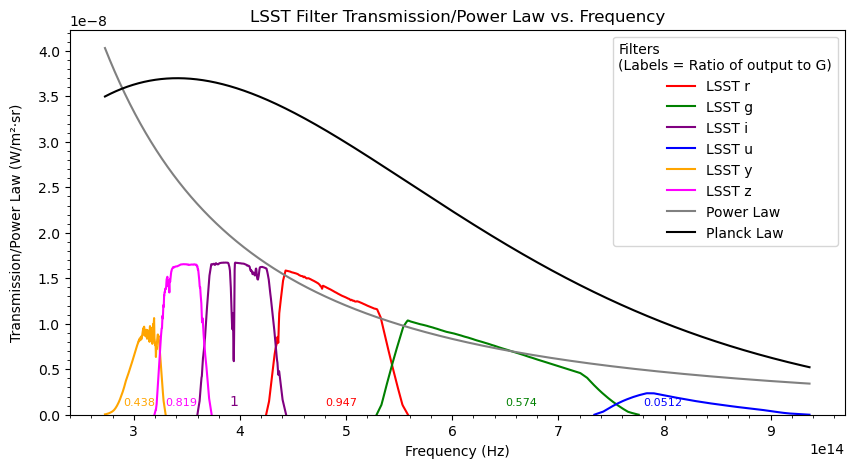

In [6]:
# Plot Code
plt.figure(figsize=(10, 5))
plt.plot(r_freq, r_trans, color='red', label='LSST r')
plt.plot(g_freq, g_trans, color='green', label='LSST g')
plt.plot(i_freq, i_trans, color='purple', label='LSST i')
plt.plot(u_freq, u_trans, color='blue', label='LSST u')
plt.plot(y_freq, y_trans, color='orange', label='LSST y')
plt.plot(z_freq, z_trans, color='magenta', label='LSST z')
#plt.plot(sorted_freq, planck_fxn(sorted_freq, t) / 2.2, label="Planck Func")
plt.plot(sorted_freq, 3e21 * sorted_freq ** -2, color='grey', label="Power Law") #power law for frequency
plt.plot(sorted_freq, planck_total, color='black', label="Planck Law")


#labels
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission/Power Law (W/m²·sr)", labelpad=10)
plt.ylim(bottom=0) # Makes y axis at 0
plt.minorticks_on()  # Add ticks inside the axis
plt.title("LSST Filter Transmission/Power Law vs. Frequency")
plt.annotate(f'{u_ratio:.3g}', (7.8e14, 0.1e-8), fontsize=8, color='blue') #for u filter
plt.annotate(f'{g_ratio:.3g}', (6.5e14, 0.1e-8), fontsize=8, color='green') #for g filter
plt.annotate(f'{r_ratio:.3g}', (4.8e14, 0.1e-8), fontsize=8, color='red') #for r filter
plt.annotate(f'{i_ratio:.3g}', (3.9e14, 0.1e-8), fontsize=10, color='purple') #for i filter
plt.annotate(f'{y_ratio:.3g}', (2.9e14, 0.1e-8), fontsize=8, color='orange') #for y filter
plt.annotate(f'{z_ratio:.3g}', (3.3e14, 0.1e-8), fontsize=8, color='magenta') #for z filter
plt.legend(title="Filters\n(Labels = Ratio of output to G)",loc='upper right')

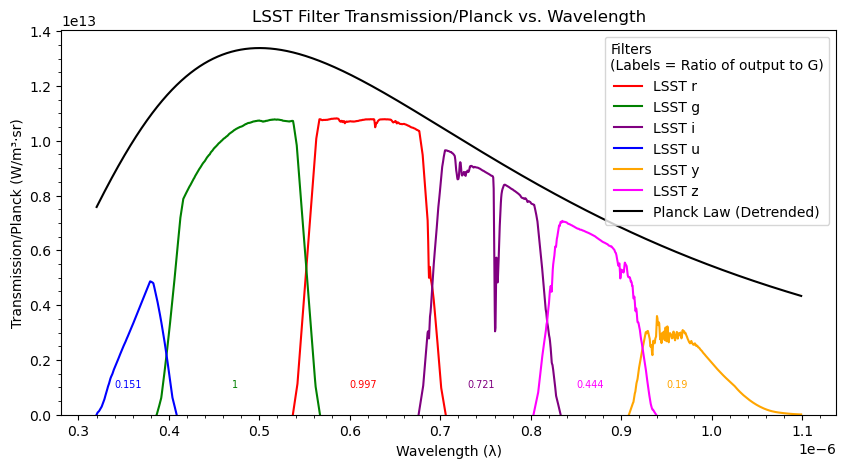

In [ ]:
# Plot Code
plt.figure(figsize=(10, 5))
plt.plot(r_wave, r_trans, color='red', label='LSST r')
plt.plot(g_wave, g_trans, color='green', label='LSST g')
plt.plot(i_wave, i_trans, color='purple', label='LSST i')
plt.plot(u_wave, u_trans, color='blue', label='LSST u')
plt.plot(y_wave, y_trans, color='orange', label='LSST y')
plt.plot(z_wave, z_trans, color='magenta', label='LSST z')
plt.plot(total_wave, planck_total, color='black', label='Planck Law (Detrended)')
#plt.plot(total_wave, flux, color='gray', linestyle='--', label='Total Transmission')

# Plot Labels 
plt.ylim(bottom=0) # Makes y axis at 0
plt.minorticks_on()  # Add ticks inside the axis
plt.xlabel("Wavelength (λ)")
plt.ylabel("Transmission/Planck (W/m³·sr)")
plt.title("LSST Filter Transmission/Planck vs. Wavelength")
plt.annotate(f'{u_ratio:.3g}', (0.34e-6, 0.1e13), fontsize=7, color='blue') #for u filter
plt.annotate(f'{g_ratio:.3g}', (0.47e-6, 0.1e13), fontsize=7, color='green') #for g filter
plt.annotate(f'{r_ratio:.3g}', (0.6e-6, 0.1e13), fontsize=7, color='red') #for r filter
plt.annotate(f'{i_ratio:.3g}', (0.73e-6, 0.1e13), fontsize=7, color='purple') #for i filter
plt.annotate(f'{y_ratio:.3g}', (0.95e-6, 0.1e13), fontsize=7, color='orange') #for y filter
plt.annotate(f'{z_ratio:.3g}', (0.85e-6, 0.1e13), fontsize=7, color='magenta') #for z filter
plt.legend(title="Filters\n(Labels = Ratio of output to G)",loc='upper right')